In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.utils as vutils

In [2]:
class PalmprintDataset(Dataset):
    def __init__(self, root_dir, transform=None, session='session1'):
        self.root_dir = os.path.join(root_dir, session)
        self.transform = transform
        self.images = []
        self.labels = []
        self.palm_names = []
        
        bmp_files = [f for f in os.listdir(self.root_dir) if f.endswith('.bmp')]
        bmp_files.sort(key=lambda x: int(x.split('.')[0]))
        
        for idx, img_file in enumerate(bmp_files):
            palm_id = idx // 10
            self.images.append(os.path.join(self.root_dir, img_file))
            self.labels.append(palm_id)
            self.palm_names.append(f"palm_{palm_id + 1:03d}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        palm_name = self.palm_names[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, palm_name

In [3]:
class LinearUpsample(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=2, mode='nearest')

In [4]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=256):
        super().__init__()
        self.fc = nn.Linear(nz, 16*16*ngf)
        self.bn0 = nn.BatchNorm2d(ngf)
        self.conv0 = nn.Conv2d(ngf, ngf, 1)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.upsample = LinearUpsample()
        self.main = nn.Sequential(
            LinearUpsample(), nn.Conv2d(ngf, ngf, 3, 1, 1), nn.BatchNorm2d(ngf), self.relu,
            nn.Conv2d(ngf, ngf//2, 3, 1, 1), nn.BatchNorm2d(ngf//2), self.relu,
            LinearUpsample(), nn.Conv2d(ngf//2, ngf//2, 3, 1, 1), nn.BatchNorm2d(ngf//2), self.relu,
            nn.Conv2d(ngf//2, ngf//4, 3, 1, 1), nn.BatchNorm2d(ngf//4), self.relu,
            LinearUpsample(), nn.Conv2d(ngf//4, ngf//4, 3, 1, 1), nn.BatchNorm2d(ngf//4), self.relu,
            nn.Conv2d(ngf//4, ngf//8, 3, 1, 1), nn.BatchNorm2d(ngf//8), self.relu,
            nn.Conv2d(ngf//8, 3, 3, 1, 1)
        )

    def forward(self, input):
        x = self.fc(input).view(-1, 256, 16, 16)
        x = self.bn0(x)
        x = self.conv0(x)
        x = self.relu(x)
        x = self.main(x)
        return self.tanh(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1), nn.BatchNorm2d(ndf), nn.Dropout(0.3), self.leaky_relu,
            nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.BatchNorm2d(ndf*2), nn.Dropout(0.3), self.leaky_relu,
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.BatchNorm2d(ndf*4), nn.Dropout(0.3), self.leaky_relu,
            nn.Conv2d(ndf*4, 1, 4, 1, 0)
        )

    def forward(self, input):
        x = self.main(input)
        x = nn.AdaptiveAvgPool2d(1)(x).view(-1)
        return x

In [6]:
def ssim_loss(gen_imgs, real_imgs):
    if len(gen_imgs) != len(real_imgs):
        real_imgs = real_imgs[:len(gen_imgs)]
    gen_scaled = ((gen_imgs + 1) * 127.5).clamp(0, 255)
    real_scaled = ((real_imgs + 1) * 127.5).clamp(0, 255)
    batch_ssim = 0
    device = gen_imgs.device
    for g, r in zip(gen_scaled, real_scaled):
        g_np = g.permute(1, 2, 0).detach().cpu().numpy()
        r_np = r.permute(1, 2, 0).detach().cpu().numpy()
        h, w = g_np.shape[:2]
        win_size = min(7, (min(h, w) // 2) * 2 + 1)
        batch_ssim += ssim(g_np, r_np, multichannel=True, data_range=255, win_size=win_size, channel_axis=2)
    return torch.tensor(batch_ssim / len(gen_imgs), device=device) * -1

In [7]:
def train_gan_per_palm(dataloader, class_id, palm_name, num_epochs=10, lr=0.0002):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    nz = 100
    G = Generator(nz).to(device)
    D = Discriminator().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    alpha = 0.5

    for epoch in range(num_epochs):
        total_lossD = 0
        total_lossG = 0
        num_batches = 0
        for i, (real_imgs, labels, _) in enumerate(dataloader):
            mask = (labels == class_id).nonzero(as_tuple=True)[0]
            if len(mask) == 0:
                continue
            real_imgs = real_imgs[mask].to(device)
            batch_size = real_imgs.size(0)
            if batch_size == 0:
                continue
            real_label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
            fake_label = torch.full((batch_size,), 0., dtype=torch.float, device=device)

            optimizerD.zero_grad()
            output_real = D(real_imgs)
            lossD_real = criterion(output_real, real_label)
            lossD_real.backward()

            noise = torch.randn(batch_size, nz, device=device)
            fake_imgs = G(noise)
            output_fake = D(fake_imgs.detach())
            lossD_fake = criterion(output_fake, fake_label)
            lossD_fake.backward()
            lossD = lossD_real + lossD_fake
            optimizerD.step()

            optimizerG.zero_grad()
            output = D(fake_imgs)
            lossG_adv = criterion(output, real_label)
            lossG_ssim = ssim_loss(fake_imgs, real_imgs)
            lossG = lossG_adv + alpha * lossG_ssim
            lossG.backward()
            optimizerG.step()

            total_lossD += lossD.item()
            total_lossG += lossG.item()
            num_batches += 1

        avg_lossD = total_lossD / num_batches if num_batches > 0 else 0
        avg_lossG = total_lossG / num_batches if num_batches > 0 else 0
        print(f'Palm {palm_name} (Class {class_id}), Epoch [{epoch+1}/{num_epochs}] Avg LossD: {avg_lossD:.4f} Avg LossG: {avg_lossG:.4f}')

    original_count = 10
    with torch.no_grad():
        noise = torch.randn(original_count * 2, nz, device=device)
        gen_imgs = G(noise).cpu()
    return gen_imgs, palm_name

In [8]:
classical_aug = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def get_model(num_classes):
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [9]:
def train_recognition(train_loader, num_epochs=20, lr=1.5e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = get_model(num_classes=600)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}')
    return model

def compute_eer(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            x = model.conv1(inputs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            features = torch.flatten(x, 1)
            all_features.append(features.cpu())
            all_labels.append(labels)
    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)
    
    n = len(all_features)
    intra_scores = []
    inter_scores = []
    for i in range(n):
        if i % 1000 == 0:  
            continue
        for j in range(i+1, min(i+100, n)):  
            sim = cosine_similarity(all_features[i:i+1], all_features[j:j+1])[0][0]
            if all_labels[i] == all_labels[j]:
                intra_scores.append(sim)
            else:
                inter_scores.append(sim)
    
    labels_for_roc = [1] * len(intra_scores) + [0] * len(inter_scores)
    scores_for_roc = intra_scores + inter_scores
    fpr, tpr, _ = roc_curve(labels_for_roc, scores_for_roc)
    eer_idx = np.argmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    return eer * 100

In [10]:
def main(base_path):
    transform = classical_aug
    train_dataset = PalmprintDataset(base_path, transform, 'session1')
    test_dataset = PalmprintDataset(base_path, transform, 'session2')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Loaded {len(train_dataset)} images from session1 ({len(set(train_dataset.labels))} palms).")

    print("Training GAN per palm...")
    gen_imgs_dict = {}
    unique_classes = len(set(train_dataset.labels))
    for class_id in range(unique_classes):
        indices = [i for i, label in enumerate(train_dataset.labels) if label == class_id]
        class_dataset = torch.utils.data.Subset(train_dataset, indices)
        class_loader = DataLoader(class_dataset, batch_size=len(indices), shuffle=True)
        palm_name = train_dataset.palm_names[indices[0]]
        gen_imgs, p_name = train_gan_per_palm(class_loader, class_id, palm_name, num_epochs=50)
        gen_imgs_dict[class_id] = (gen_imgs, p_name)
        vutils.save_image((gen_imgs[:4] + 1)/2, f"{p_name}_synths.png", nrow=2, normalize=True)
        print(f"Generated {len(gen_imgs)} synthetic images for {p_name} (Class {class_id})")

    print("Training Xception...")
    model = train_recognition(train_loader, num_epochs=20)

    eer = compute_eer(model, test_loader)
    print(f'EER on Session 2: {eer:.4f}%')

    return gen_imgs_dict

base_path = r"C:\Users\hiteshk\Desktop\Deep Learning Approaches for roi extraction and using same for palm print recognisation\Tonji\ROI"
gen_imgs_dict = main(base_path)

Loaded 6000 images from session1 (600 palms).
Training GAN per palm...
Palm palm_001 (Class 0), Epoch [1/50] Avg LossD: 1.4369 Avg LossG: 0.6860
Palm palm_001 (Class 0), Epoch [2/50] Avg LossD: 1.2848 Avg LossG: 0.8235
Palm palm_001 (Class 0), Epoch [3/50] Avg LossD: 1.1601 Avg LossG: 0.9409
Palm palm_001 (Class 0), Epoch [4/50] Avg LossD: 1.0765 Avg LossG: 0.9880
Palm palm_001 (Class 0), Epoch [5/50] Avg LossD: 1.0296 Avg LossG: 1.0634
Palm palm_001 (Class 0), Epoch [6/50] Avg LossD: 1.0173 Avg LossG: 1.0892
Palm palm_001 (Class 0), Epoch [7/50] Avg LossD: 0.9837 Avg LossG: 1.1270
Palm palm_001 (Class 0), Epoch [8/50] Avg LossD: 0.9807 Avg LossG: 1.1113
Palm palm_001 (Class 0), Epoch [9/50] Avg LossD: 0.9462 Avg LossG: 1.2814
Palm palm_001 (Class 0), Epoch [10/50] Avg LossD: 0.8611 Avg LossG: 1.4782
Palm palm_001 (Class 0), Epoch [11/50] Avg LossD: 0.7491 Avg LossG: 1.6383
Palm palm_001 (Class 0), Epoch [12/50] Avg LossD: 0.7370 Avg LossG: 1.5616
Palm palm_001 (Class 0), Epoch [13/50]

C:\Users\hiteshk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hiteshk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20] Loss: 5.5971
Epoch [2/20] Loss: 2.0720
Epoch [3/20] Loss: 0.3785
Epoch [4/20] Loss: 0.1002
Epoch [5/20] Loss: 0.0486
Epoch [6/20] Loss: 0.0253
Epoch [7/20] Loss: 0.0149
Epoch [8/20] Loss: 0.0104
Epoch [9/20] Loss: 0.1773
Epoch [10/20] Loss: 0.1596
Epoch [11/20] Loss: 0.0184
Epoch [12/20] Loss: 0.0061
Epoch [13/20] Loss: 0.0041
Epoch [14/20] Loss: 0.0031
Epoch [15/20] Loss: 0.0025
Epoch [16/20] Loss: 0.0020
Epoch [17/20] Loss: 0.0017
Epoch [18/20] Loss: 0.0015
Epoch [19/20] Loss: 0.0013
Epoch [20/20] Loss: 0.0011
EER on Session 2: 1.1352%


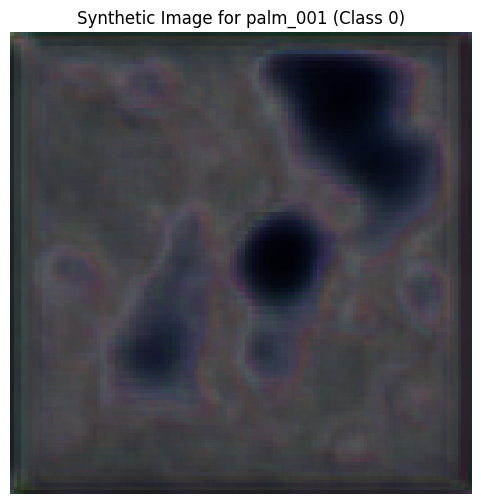

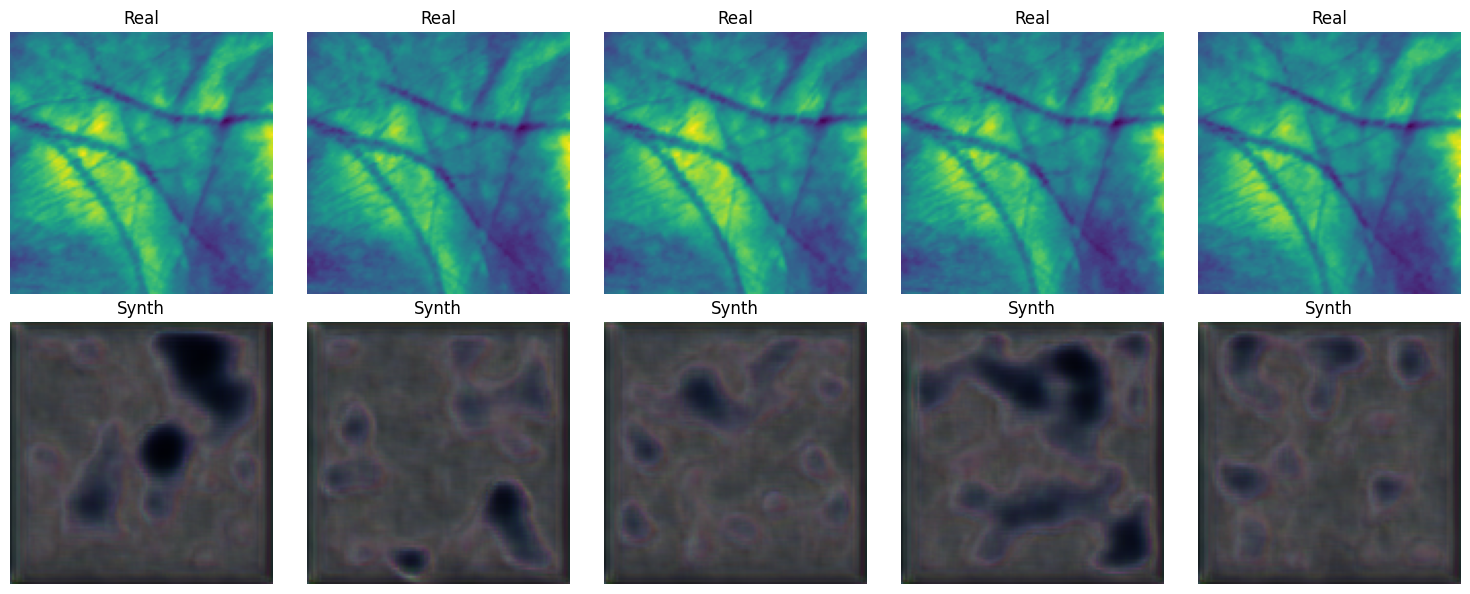

In [14]:
# Re-define for scope
transform = classical_aug
train_dataset = PalmprintDataset(base_path, transform, 'session1')

class_id = 0
gen_imgs, palm_name = gen_imgs_dict[class_id]
plt.figure(figsize=(6, 6))
plt.imshow((gen_imgs[0].permute(1, 2, 0) + 1) / 2)
plt.title(f"Synthetic Image for {palm_name} (Class {class_id})")
plt.axis('off')
plt.show()

real_paths = train_dataset.images[:5]  # First 5 reals
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for j, path in enumerate(real_paths):
    img = Image.open(path).resize((128, 128))
    axs[0, j].imshow(img)
    axs[0, j].set_title('Real')
    axs[0, j].axis('off')
gen_sample = gen_imgs[:5]  # First 5 synths
for j, gen in enumerate(gen_sample):
    axs[1, j].imshow((gen.permute(1,2,0)+1)/2)
    axs[1, j].set_title('Synth')
    axs[1, j].axis('off')
plt.tight_layout()
plt.show()

In [16]:
def compute_ssim_metrics(gen_imgs_dict, train_dataset):
    ssim_scores = {}
    for class_id in gen_imgs_dict:
        gen_imgs, palm_name = gen_imgs_dict[class_id]
        real_indices = [i for i, label in enumerate(train_dataset.labels) if label == class_id][:10]
        real_imgs = []
        for idx in real_indices:
            real_img, _, _ = train_dataset[idx]  
            real_imgs.append(real_img)
        real_imgs = torch.stack(real_imgs)
        
        batch_ssim = 0
        for gen in gen_imgs[:5]:
            for real in real_imgs:
                gen_np = ((gen + 1) * 127.5).permute(1, 2, 0).detach().cpu().numpy()
                real_np = ((real + 1) * 127.5).permute(1, 2, 0).detach().cpu().numpy()
                h, w = gen_np.shape[:2]
                win_size = min(7, (min(h, w) // 2) * 2 + 1)
                batch_ssim += ssim(gen_np, real_np, multichannel=True, data_range=255, win_size=win_size, channel_axis=2)
        avg_ssim = batch_ssim / (5 * 10)
        ssim_scores[palm_name] = avg_ssim
        print(f"Avg SSIM for {palm_name}: {avg_ssim:.4f}")
    return ssim_scores

ssim_metrics = compute_ssim_metrics(gen_imgs_dict, train_dataset)
print("Overall Avg SSIM:", np.mean(list(ssim_metrics.values())))

Avg SSIM for palm_001: 0.5328
Avg SSIM for palm_002: 0.4407
Avg SSIM for palm_003: 0.3330
Avg SSIM for palm_004: 0.3911
Avg SSIM for palm_005: 0.5252
Avg SSIM for palm_006: 0.5091
Avg SSIM for palm_007: 0.4482
Avg SSIM for palm_008: 0.3078
Avg SSIM for palm_009: 0.4238
Avg SSIM for palm_010: 0.3180
Avg SSIM for palm_011: 0.4337
Avg SSIM for palm_012: 0.3051
Avg SSIM for palm_013: 0.3295
Avg SSIM for palm_014: 0.3996
Avg SSIM for palm_015: 0.3513
Avg SSIM for palm_016: 0.3370
Avg SSIM for palm_017: 0.3457
Avg SSIM for palm_018: 0.3062
Avg SSIM for palm_019: 0.3275
Avg SSIM for palm_020: 0.3502
Avg SSIM for palm_021: 0.3636
Avg SSIM for palm_022: 0.3054
Avg SSIM for palm_023: 0.3638
Avg SSIM for palm_024: 0.2834
Avg SSIM for palm_025: 0.4106
Avg SSIM for palm_026: 0.3697
Avg SSIM for palm_027: 0.3553
Avg SSIM for palm_028: 0.2986
Avg SSIM for palm_029: 0.3807
Avg SSIM for palm_030: 0.3325
Avg SSIM for palm_031: 0.2659
Avg SSIM for palm_032: 0.3349
Avg SSIM for palm_033: 0.3361
Avg SSIM f